In [ ]:
#Import Libraries

import numpy as np #Numerical Computing.
import os #I/O.
import tensorflow as tf #Machine Learning.
from tensorflow.keras.preprocessing import image_dataset_from_directory #Dataset Generator.
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from skimage.transform import resize
from skimage.io import imread
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
from sklearn import svm
import pandas as pd
import pickle
from sklearn import metrics
import cv2 
import random

from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.filters.rank import entropy
from skimage.morphology import disk
tf.test.gpu_device_name()

'/device:GPU:0'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip "../content/drive/MyDrive/Bio/Data.zip" -d "/content"

scegli il canale [r, g, b]2
blu
[[ 37  52  65 ... 227 220 211]
 [ 55  54  57 ... 226 223 214]
 [ 92  74  65 ... 227 216 199]
 ...
 [209 209 209 ... 210 210 210]
 [209 209 209 ... 210 210 210]
 [209 209 209 ... 210 210 210]]


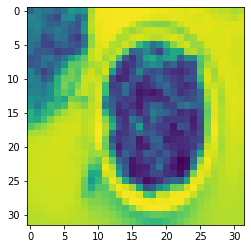

blu


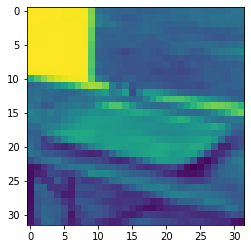

bio -> 6000
no_bio -> 6000


In [ ]:
# A questo punto uso la PCA per trainare il modello

Categories = ['B','N']
flat_data_arr = []
target_arr = []


bio_file = []
no_bio_file = []


#per rendere gli esperimenti riproducibili
random.seed(77)

choose = int(input("scegli il canale [r, g, b]"))

#Concateno tutte le immagini

for indice in range(1,5):
  pathb = '../content/TRAIN.'+str(indice)+'/B'
  pathnb = '../content/TRAIN.'+str(indice)+'/N'

  bio_file +=  [pathb+'/'+fn for fn in os.listdir('../content/TRAIN.'+str(indice)+'/B') if ("ORI" in fn) ]
  no_bio_file +=  [pathnb+'/'+fn for fn in os.listdir('../content/TRAIN.'+str(indice)+'/N') if ("ORI" in fn)]


#metto alla pari le due classi
fn_bio = random.sample(bio_file,6000)
fn_nobio = random.sample(no_bio_file,6000)

conteggio = 0



#immagini non divise in RGB
for i in range (len(fn_bio)):
  conteggio +=1
  for j in range(2):
    #BIO
    if j==0:
      #leggo l'immagine
      immagine = imread(os.path.join(fn_bio[i]))

      #ANALISI RGB
      (r,g,b) = cv2.split(immagine)
      if(choose == 0):
        imgc = r

        if conteggio==10:
          print("rosso")
          print(r)
          plt.imshow(r)
          plt.show()
        
      elif(choose == 1):
        imgc = g
        if conteggio==10:
          print("verde")
          print(g)
        
      elif(choose == 2):
        imgc = b
        if conteggio==10:
          print("blu")
          print(b)
      else:
        imgc = immagine
        if conteggio==10:
          print("3 colori")

      img_resize = resize(imgc, (32,32))
      flat_data_arr.append(img_resize.flatten())
      target_arr.append(Categories.index(Categories[j]))

      if conteggio==10:
        plt.imshow(img_resize)
        plt.show()

    #NON BIO
    if j==1:
      #leggo l'immagine
      immagine = imread(os.path.join(fn_nobio[i]))

      #ANALISI RGB
      (r,g,b) = cv2.split(immagine)

      if(choose == 0):
        imgc = r
        if conteggio==10:
          print("rosso")
        
      elif(choose == 1):
        imgc = g
        if conteggio==10:
          print("verde")
      elif(choose == 2):
        imgc = b
        if conteggio==10:
          print("blu")
      else:
        imgc = immagine
        if conteggio==10:
          print("3 colori")

      img_resize = resize(imgc, (32,32))
      
      flat_data_arr.append(img_resize.flatten())
      target_arr.append(Categories.index(Categories[j]))

      if conteggio==10:
        plt.imshow(img_resize)
        plt.show()
                         
#Abbiamo ora un dataset perfettamente bilanciato
print(f"bio -> {len(fn_bio)}")
print(f"no_bio -> { len(fn_nobio)}")



flat_data = np.array(flat_data_arr)
target = np.array(target_arr)

df = pd.DataFrame(flat_data)
df['Target'] = target




In [ ]:
x=df.iloc[:,:-1] # qui prendo l'immagine (tranne la label)
y=df.iloc[:,-1] # qui prendo solo la label


print(np.unique(y))

x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20,random_state=77,stratify=y)



[0 1]


In [ ]:
scelta_modello = int(input("scegli il modello:"))

#SVM
if(scelta_modello == 0):
  param_grid={'C':[10,0.1],'kernel':['linear','poly','rbf'], 'gamma':[0.1,1]} 
 # param_grid={'C':[1],'kernel':['poly'], 'gamma':[0.1]} 


  #param_grid={'kernel':['rbf','poly'], 'gamma':[1, 10,100]}
  #param_grid = {'C': [0.1], 'kernel': ['linear']}
  #param_grid = {'C': [0.01], 'gamma':[0.1], 'kernel': ['linear']}

  svc=svm.SVC(probability=True)
  print("inizio allenamento")
  model=GridSearchCV(svc,param_grid, verbose=1)  

  # test if CPU and GPU are visible
  c = tf.config.get_visible_devices()
  print(c)
  # [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
  #  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]  

  model.fit(x_train,y_train)
  print('Fine allenamento')
  print(model.best_params_)

#RANDOM FOREST
elif(scelta_modello == 1):
 # param_grid = {'bootstrap':[True], 'n_estimators':[300,400,500], 'max_depth':[50,70]}
  param_grid = {'bootstrap':[True], 'n_estimators':[100], 'criterion':['gini', 'entropy', 'log_loss'],'max_depth':[50,70], 'max_features':['sqrt','log2','auto']}
  clf=RandomForestClassifier(n_estimators=100)
  print("inizio allenamento")
  model=GridSearchCV(clf, param_grid)
  model.fit(x_train,y_train)
  print("fine allenamento")
  print (model.best_params_)


#KNN
elif(scelta_modello == 2):
  knn = KNeighborsClassifier()
 # k_range = list(range(3,15,2))
 
  #param_grid ={'metric': ['manhattan'], 'n_neighbors': [5], 'weights': ['distance']}
  #param_grid ={'metric': ['euclidean'], 'n_neighbors': [5], 'weights': ['distance']}
  param_grid ={'metric': ['manhattan'], 'n_neighbors': [7], 'weights': ['distance']}
  #param_grid = dict(n_neighbors = k_range, weights = ["distance"], metric=["manhattan"])
  grid = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy', return_train_score=True, verbose=2)
  #fitting the model for grid search
  grid_search = grid.fit(x_train, y_train)
  print(grid_search.best_params_)
  model = grid_search

In [ ]:
y_pred = model.predict(x_test)
print(f"predizione modello -> {y_pred}")
print(f"label reali -> {np.array(y_test)}")

predizione modello -> [1 1 1 ... 0 1 0]
label reali -> [1 1 0 ... 0 1 0]


The model is 85.04166666666667% accurate


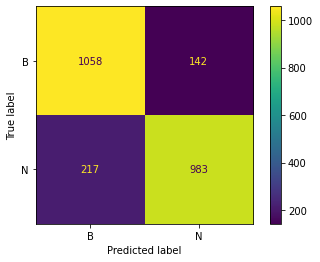

Precision: 87.37777777777778% 
Sensitivity: 81.91666666666667% 
Specificity: 88.16666666666667% 
F-Score: 84.55913978494624
GridSearchCV(estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True], 'max_depth': [30, 50, 70],
                         'max_features': ['sqrt', 'log2', 'auto'],
                         'n_estimators': [50]})


In [ ]:
#vediamo l'accuratezza:
print(f"The model is {accuracy_score(y_pred,y_test)*100}% accurate")
#Confusion matrix
confusion_matrix = metrics.confusion_matrix(y_test,y_pred)
cm_display = metrics.ConfusionMatrixDisplay (confusion_matrix = confusion_matrix, display_labels = ['B','N'])
cm_display.plot()
plt.show()
#Metrics
#of the positives predicted, what percentage is truly positive?
precision = metrics.precision_score(y_test, y_pred)
print(f"Precision: {precision*100}% ")
#how good the model is at predicting positives?
sensitivity_recall = metrics.recall_score(y_test, y_pred)
print(f"Sensitivity: {sensitivity_recall*100}% ")
#how good the model is at predicting negatives?
specificity = metrics.recall_score(y_test, y_pred, pos_label=0)
print(f"Specificity: {specificity*100}% ")
f1_score = metrics.f1_score(y_test, y_pred)
print(f"F-Score: {f1_score * 100}")
print(model)